[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)

#### based on Fig. 1 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [101]:
from matplotlib import pylab
import numpy as np

# import sys
# sys.path.insert(0,"/Users/claresinger/Research/PySDM")
# print(sys.path)

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics import constants_defaults as const
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer.aerosol import AerosolBetaCary

In [110]:
cases = {'BetaCary': AerosolBetaCary()}
aer = AerosolBetaCary()

formulae_bulk = Formulae(surface_tension='Constant')

formulae_ovad = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants={
        'sgm_org': 34.77 * si.mN / si.m,
        'delta_min': 1.73 * si.nm  # TODO #604 0.2 in the paper, but 0.1 matches the paper plots
    }
)

formulae_ruehl = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        'RUEHL_nu_org': aer.aerosol_modes_per_cc[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_m_sigma': 0.3e17 * si.J / si.m**2,
        'RUEHL_sgm_min': 40 * si.mN / si.m
    }
)

from scipy import constants as sci
from scipy import optimize
def sigR(T, v_wet, v_dry, f_org):
    nu_org= aer.aerosol_modes_per_cc[0]['nu_org']
    A0= 115e-20 * si.m * si.m
    C0= 6e-7
    m_sigma = 0.3e17 * si.J / si.m**2
    sgm_min = 34.77 * si.mN / si.m
    
    r_wet = ((3 * v_wet) / (4 * np.pi))**(1/3) # m - wet radius

    # C_bulk is the concentration of the organic in the bulk phase
    Cb_iso = (f_org*v_dry/nu_org) / (v_wet/const.nu_w) # = C_bulk / (1-f_surf)

    # A is the area that one molecule of organic occupies at the droplet surface
    A_iso = (4 * np.pi * r_wet**2) / (f_org * v_dry * sci.N_A / nu_org) # m^2 = A*f_surf

    # solve implicitly for fraction of organic at surface
    a = A0 / A_iso
    c = Cb_iso / C0
    f = lambda f_surf: a*f_surf - (c*(1-f_surf)) / (1 + c*(1-f_surf))
    sol = optimize.root_scalar(f, bracket=[0, 1])
    f_surf = sol.root

    # calculate surface tension
    sgm = const.sgm_w - ((sci.R*T)/(A0*sci.N_A)) * np.log(1 + Cb_iso*(1-f_surf)/C0)
    sgm = np.minimum(np.maximum(sgm, sgm_min), const.sgm_w)
    return sgm

## from Ryan
# A0=115, ln(C0)=-4, and m=0.3
# MW_inorg = 132;  # ammonium sulfate
# MW_H2O = 0.018015;
# VHF_org = 1;     # vant hoff factor
# VHF_inorg = 2.6;
# pw = 997;
# rho_inorg = 1.77 * 1e3;  # kg m-3 
# MW_inorg = 0.13214;       # kg mol-1
# rho_org = 905;             # kg m-3
# MW_org = 0.20436;         # kg mol-1

# formulae_sl = Formulae(
#     surface_tension='SzyszkowskiLangmuir',
#     constants={
#         'RUEHL_nu_org': aer.aerosol_modes_per_cc[0]['nu_org'],
#         'RUEHL_A0': 115e-20 * si.m * si.m,
#         'RUEHL_C0': 6e-7,
#         'RUEHL_sgm_min': 40 * si.mN / si.m
#     }
# )
formulae_sl = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        'RUEHL_nu_org': aer.aerosol_modes_per_cc[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_m_sigma': 0.3e17 * si.J / si.m**2,
        'RUEHL_sgm_min': 40 * si.mN / si.m
    }
)

def sigSL(T, v_wet, v_dry, f_org):
    nu_org= aer.aerosol_modes_per_cc[0]['nu_org']
    A0= 110e-20 * si.m * si.m
    C0= 6e-7
    sgm_min = 34.77 * si.mN / si.m
    
    r_wet = ((3 * v_wet) / (4 * np.pi))**(1/3) # m - wet radius

    # C_bulk is the concentration of the organic in the bulk phase
    Cb_iso = (f_org*v_dry/nu_org) / (v_wet/const.nu_w) # = C_bulk / (1-f_surf)

    # A is the area that one molecule of organic occupies at the droplet surface
    A_iso = (4 * np.pi * r_wet**2) / (f_org * v_dry * sci.N_A / nu_org) # m^2 = A*f_surf

    a = -A0 / A_iso
    b = A0 / A_iso + (A0 / A_iso)*(C0 / Cb_iso) + 1
    c = -1
    f_surf = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

    # calculate surface tension
    sgm = const.sgm_w - ((sci.R*T)/(A0*sci.N_A)) * np.log(1 + Cb_iso*(1-f_surf)/C0)
    sgm = np.minimum(np.maximum(sgm, sgm_min), const.sgm_w)
    return sgm

r_wet = np.logspace(np.log(50 * si.nm), np.log(2000 * si.nm), base=np.e, num=100)
r_dry = 50 * si.nm
v_wet = formulae_ovad.trivia.volume(r_wet)
v_dry = formulae_ovad.trivia.volume(r_dry)
T=300 * si.K
r_wet_ticks_nm = (100,300, 500, 1000, 2000)
lines = {'bulk': '-', 'Ovad': '--', 'Ruehl': ':', 'SL': '-.'}

### Surface tension

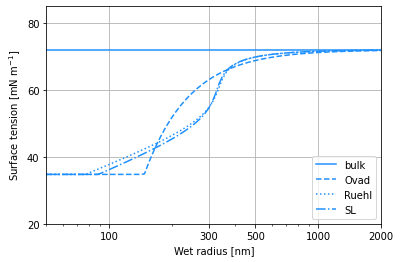

In [111]:
for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl, 'SL': formulae_sl}.items():
    for k, v in cases.items():
        sigma = np.zeros(len(v_wet))
        if label == "bulk":
            sigma = np.ones(len(v_wet)) * formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        elif label == "Ruehl":
            for i, vw in enumerate(v_wet):
                sigma[i] = sigR(T, vw, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        elif label == "SL":
            sigma = sigSL(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        
        pylab.plot(r_wet / si.nm, sigma / (si.mN / si.m), label=label, color=v.color, linestyle=lines[label])

pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
yticks = (20, 40, 60, 80)
pylab.yticks(yticks, yticks)
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylim(20, 85)
pylab.xlabel('Wet radius [nm]')
pylab.ylabel('Surface tension [mN m$^{-1}$]')
pylab.legend(loc=4)
pylab.show()
#show_plot()

### Kohler curves

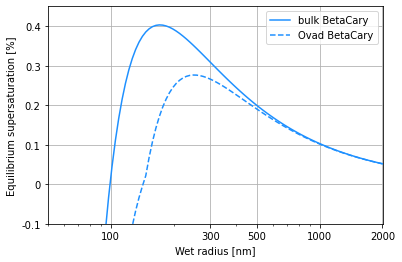

[[ 5.00000000e-08 -6.12513708e+00 -7.20069018e+00]
 [ 5.18982159e-08 -5.33341363e+00 -6.36962757e+00]
 [ 5.38684963e-08 -4.63068876e+00 -5.62900240e+00]
 [ 5.59135770e-08 -4.00735720e+00 -4.96915678e+00]
 [ 5.80362979e-08 -3.45483661e+00 -4.38145765e+00]
 [ 6.02396063e-08 -2.96545913e+00 -3.85818832e+00]
 [ 6.25265619e-08 -2.53237440e+00 -3.39245136e+00]
 [ 6.49003402e-08 -2.14946289e+00 -2.97808188e+00]
 [ 6.73642374e-08 -1.81125832e+00 -2.60956996e+00]
 [ 6.99216747e-08 -1.51287843e+00 -2.28199122e+00]
 [ 7.25762034e-08 -1.24996290e+00 -1.99094483e+00]
 [ 7.53315095e-08 -1.01861805e+00 -1.73249801e+00]
 [ 7.81914189e-08 -8.15367188e-01 -1.50313645e+00]
 [ 8.11599028e-08 -6.37106386e-01 -1.29971998e+00]
 [ 8.42410832e-08 -4.81064841e-01 -1.11944285e+00]
 [ 8.74392385e-08 -3.44769471e-01 -9.59798326e-01]
 [ 9.07588096e-08 -2.26013257e-01 -8.18546974e-01]
 [ 9.42044059e-08 -1.22826942e-01 -6.93688296e-01]
 [ 9.77808119e-08 -3.34537184e-02 -5.83435394e-01]
 [ 1.01492994e-07  4.36733878e-

In [5]:
rd3 = r_dry**3

dat = np.zeros((len(r_wet), 3))
dat[:,0] = r_wet
i = 1

# for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl, 'SL': formulae_sl}.items():
for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad}.items():
    for k, v in cases.items():
        sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        RH_eq = formulae.hygroscopicity.RH_eq(r_wet, T, v.aerosol_modes_per_cc[0]['kappa'][label], rd3, sigma)
        pylab.plot(
            r_wet / si.nm, 
            (RH_eq - 1)*100, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
        dat[:,i] = (RH_eq - 1)*100
        i += 1
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
pylab.xlabel('Wet radius [nm]')
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylabel('Equilibrium supersaturation [%]')
yticks = (-.1, 0, .1, .2, .3, .4)
pylab.yticks(yticks, yticks)
pylab.ylim(yticks[0], .45)
pylab.legend()
pylab.show()
#show_plot()

print(dat)
np.savetxt("Ryan_kohler.csv", dat, delimiter=',', fmt='%.4e', header="r wet (m), SS (bulk), SS (film)")

### Critical radius

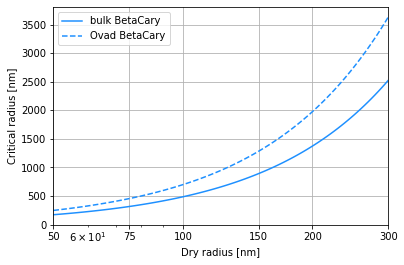

In [6]:
r_dry = np.logspace(np.log(50 * si.nm), np.log(300 * si.nm), base=np.e, num=100)
v_dry = formulae_ovad.trivia.volume(r_dry)
rd3 = r_dry**3

#for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl, 'SL': formulae_sl}.items():
for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad}.items():
    for k, v in cases.items():
        sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc[0]['kappa'][label], rd3, T, sigma)
        
        pylab.plot(
            r_dry / si.nm, 
            rcrit / si.nm, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
pylab.grid()
pylab.xscale('log')
r_dry_ticks_nm = (50, 75, 100, 150, 200, 300)
pylab.xticks(r_dry_ticks_nm, r_dry_ticks_nm)
pylab.xlabel('Dry radius [nm]')
pylab.xlim(r_dry[0] / si.nm, r_dry[-1] / si.nm)
pylab.ylabel('Critical radius [nm]')
#yticks = (-.1, 0, .1, .2, .3)
#pylab.yticks(yticks, yticks)
#pylab.ylim(yticks[0], .35)
pylab.legend()
pylab.show()
#show_plot()

### Effective Hygroscopicity, $\kappa_{eff}$

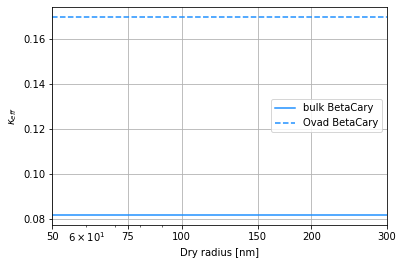

In [7]:
# for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl, 'SL': formulae_sl}.items():
for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad}.items():
    for k, v in cases.items():
        sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc[0]['kappa'][label], rd3, T, sigma)
        kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w
        
        pylab.plot(
            r_dry / si.nm, 
            kap_eff, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_dry_ticks_nm, r_dry_ticks_nm)
pylab.xlabel('Dry radius [nm]')
pylab.xlim(r_dry[0] / si.nm, r_dry[-1] / si.nm)
pylab.ylabel('$\kappa_{eff}$')
pylab.legend()
pylab.show()
#show_plot()

### Aerosol size distribution

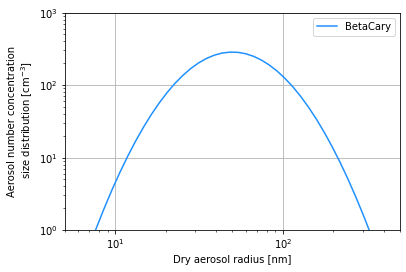

In [8]:
x = np.logspace(np.log(5 * si.nm), np.log(1000 * si.nm), base=np.e)
for k, v in cases.items():
    spec = v.aerosol_modes_per_cc[0]['spectrum']
    pylab.loglog(x / si.nm, spec.size_distribution(x)*x / si.cm**-3, label=k, color=v.color)
pylab.ylim(1, 1000)
pylab.xlim(5, 500)
pylab.legend()
pylab.grid()
pylab.xlabel('Dry aerosol radius [nm]')
pylab.ylabel('Aerosol number concentration\n size distribution [cm$^{-3}$]')
pylab.show()
#show_plot()